In [42]:
import os

import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from sklearnex import patch_sklearn
from tqdm.notebook import tqdm

# patch_sklearn()

import tensorflow as tf
from tensorflow import keras
from keras import layers
from scikeras.wrappers import KerasClassifier

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, StratifiedKFold, \
    train_test_split, GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from utils import OneHotEncoder

from xgboost import XGBClassifier

print(tf.__version__)
print(tf.keras.__version__)
random_state = 2111

2.11.0
2.9.0


In [2]:
df = pd.read_csv('./slac/Contents of SLAC/slac.csv', usecols=['id','genre', 'subgenre', 'title'])
ids = df.id.tolist()
path = './slac/embeddings/'
emb = KeyedVectors.load_word2vec_format(path+'slac.bin')
data = np.array([emb[i] for i in ids])
emb_sets = {
    'ALL' : data,
}

In [3]:
genre = np.array(df.genre).reshape(-1, 1)

lb = LabelBinarizer()
lb_labels = lb.fit_transform(genre)

num_input, num_output = data.shape[1], lb_labels.shape[1]

print(f'genre.shape={genre.shape}',
      f'lb.classes_={lb.classes_}',
      f'data.shape={data.shape}',
      f'lb_labels.shape={lb_labels.shape}',
      f'(num_input, num_output)={(num_input, num_output)}', sep='\n')


genre.shape=(250, 1)
lb.classes_=['Blues' 'Classical' 'Jazz' 'Rap' 'Rock']
data.shape=(250, 100)
lb_labels.shape=(250, 5)
(num_input, num_output)=(100, 5)


(array([38.,  0., 40.,  0.,  0., 41.,  0., 43.,  0., 38.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

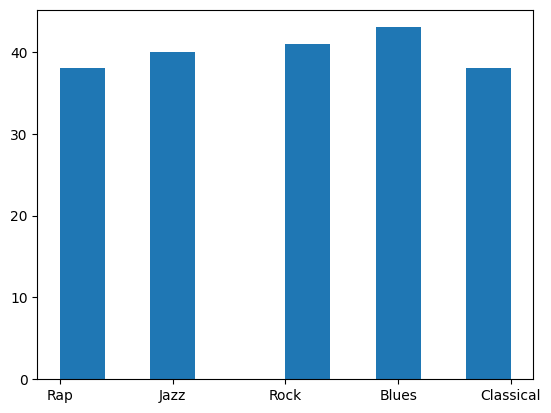

In [4]:
# Paper does not split data; Cross val score without split is (with alpha_rate=.2) ~0.876 > 0.864

X_train, X_test, y_train, y_test = train_test_split(
    data, lb_labels, test_size=0.20, random_state=random_state)

plt.hist(lb.inverse_transform(y_train))

In [28]:
xgb = XGBClassifier(predictor='cpu_predictor')


scores_xgb = cross_val_score(xgb, X_train, y_train,
                              cv=KFold(10, shuffle=True, random_state=random_state), n_jobs=-1, verbose=0)

print(scores_xgb)
m_xgb = np.mean(scores_xgb)
s_xgb = np.std(scores_xgb)
print('Accuracy: %.3f (%.3f)' % (m_xgb, s_xgb))

[0.35 0.5  0.3  0.4  0.35 0.25 0.25 0.5  0.3  0.4 ]
Accuracy: 0.360 (0.086)


In [47]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=.2, random_state=random_state)

parameters1 = {"n_estimators" : [500, 1000, 2000], "learning_rate" : [0.05 , 0.1, 0.3], "max_depth" : [3 , 5 , 10]}

# fit_params = {"early_stopping_rounds" : 20, "eval_set" : [(X_val, y_val)]}

clf = GridSearchCV(xgb, parameters1, scoring='accuracy', n_jobs=4, verbose=2, cv=KFold(10, shuffle=True, random_state=random_state).split(X_train2, y_train2))

clf.fit(X_train, y_train)


Fitting 10 folds for each of 27 candidates, totalling 270 fits


GridSearchCV(cv=<generator object _BaseKFold.split at 0x0000026BC4BC2350>,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=N...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                              

In [48]:
print(clf.best_params_, clf.best_score_)

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500} 0.30625


In [ ]:
xgb_f = clf.best_estimator_

